In [1]:
%matplotlib inline
from notebook.auth import passwd
import numpy as np
import struct
from ctypes import c_uint32
import matplotlib.pyplot as plt

# [Seismic] Data Encryption
This notebook paves the way for the 52 Things You Should Know About Geocomputing: [Seismic] Data Encryption chapter. Since we'll be encrypting and decrypting things in this notebook, we'll always use the same password:

> is_52_ytpeieonncr_iTghsn_kye._oru_hTsi

Strong passwords are long passwords. Strength is added when the number of possible symbols increases, hence the punctuation and capitals in our password. Mixing up letters and words reduces the possibility of attack by [dictionary methods](http://web.cs.du.edu/~mitchell/forensics/information/pass_crack.html). Just start with a sentence like "*This is our 52 Things encryption key.*" Jumble up the letters and words from there. And I've used underscores in place of spaces here.

By the way, in the event you're storing your password on a computer (or a GitHub repo), never store it in *plaintext*. That is to say, don't just make a Google Document containing all your passwords. Anyone who gains access to the document (like this one) would now have your password (like the above). There's a process called hashing a password, which we'll now do using a simple Jupyter tool.

In [2]:
passwd()

Enter password: ········
Verify password: ········


'sha1:5cc7f477af13:d9ffe76af091e0246fa7d2afd087ba02d8e7c423'

And that's it. This hash was built using SHA1, which is now trivially breakable. Python has some other awesome tools to perform hashing if you need realistically strong hashes ([with salt](https://en.wikipedia.org/wiki/Salt_(cryptography), etc.). Again, for the remainder of this notebook we'll use the above password in its plaintext form. I only mentioned hashing to get your wheels turning.

## Load seismic data into an array

The file we're loading is located in this repo under the `data` folder. I've already stripped a segy file down into and array of binary floats, so we don't require any special seismic manipulation tools. The array is of size 390 x 276.

**The seismic data used in this publication was obtained from [RMOTC and the U.S. Department of Energy](https://energy.gov/node/1012461/datasets.html) via the [SEG](http://wiki.seg.org/wiki/Teapot_dome_3D_survey).**

First we grab Numpy and set our size:

In [3]:
ntr = 390
ns  = 276

Then we build an array

In [4]:
plain = np.zeros((ns, ntr))

and populate it with samples

In [5]:
with open('data/seis.bin', 'rb') as f:
    for i in range(ntr):
        for j in range(ns):
            plain[j,i] = struct.unpack('f', f.read(4))[0]

## How does image encryption do its thing?

![TEA Encryption Algorithm Cartoon](img/TEA_protocol_cartoon.png "TEA Encryption Algorithm Cartoon")

In this section let's explore how we can encrypt an image. The algorithm we'll build here is based on the [TEA (Tiny Encryption Algorithm)](http://citeseer.ist.psu.edu/viewdoc/download;jsessionid=C08E8409ADF484095568965A1EBF3E5E?doi=10.1.1.45.281&rep=rep1&type=pdf) cryptographic protocol. It is a symmetric encryption algorithm, meaning we'll use the same password (the one above) to both encrypt and decrypt the data.


**This code is not acceptable for real encryption. It is a demonstration toy. Do not use it to protect sensitive data!!!**


Additionally, even a good implementation of TEA isn't strong against modern cryptanalysis. But it is a really good demonstration of how modern cryptography works. Also, yes, I realize Python is a horrible language to do this in.

In [6]:
class tea(object):

    def __init__(self, data, pswrd):
        self.data = data
        self.pswrd = pswrd
        self.cycles = 32
        self.d_const = 0x9e3779b9 # Wheeler's key schedule constant, from Golden Ratio
        self.s_const = 0xc6ef3720 # Wheeler's Delta << 5 (left bit shift)
        self.precision = 1000000 # precision for converting floats to c_uint32's
    

    def encrypt_piece(self, dat, key):
        # dat, here, is two 4 byte words. key is four 4 byte words
        
        summ = c_uint32(0)
        delta = c_uint32(self.d_const)

        for idx in range(0, self.cycles):
            summ.value += delta.value
            # at each cycle, bit shift and XOR, recombining key words recursively (see img abv)
            dat[0].value += ((dat[1].value << 4) + key[0].value) ^ (dat[1].value + summ.value) ^ ((dat[1].value >> 5) + key[1].value)
            dat[1].value += ((dat[0].value << 4) + key[2].value) ^ (dat[0].value + summ.value) ^ ((dat[0].value >> 5) + key[3].value)

        return dat
    
    
    def byte_splitta(self):
        # this sucker splits out float data into c_uint32 words
        
        byts = []
    
        for idx in range(len(self.data)):
            temp = c_uint32(int(struct.unpack('f', temp_data[idx])[0] * self.precision))
            byts.append(temp)
    
        return (byts)
    
    
    def build_key(self, passin):
        # builds c_uint32 words from a key
        
        ckey = []
        bytelist = [ord(char) for char in passin] # get ints from string chars
        
        for index in range(0, len(bytelist), 4):
            chunk = bytelist[index:index + 4] # chunk out ints for words
            temp = ''.join((str(chunk[0]),str(chunk[1]),str(chunk[2]),str(chunk[3]))) # concatenate ints
            ckey.append(c_uint32(int(temp))) # string -> int -> c_uint32
            
        return ckey

    
    def forward(self):
        # push plaindata through the bit splitter and encryption
        
        d_bytes = self.byte_splitta() # build word list from data
        
        passin = self.pswrd[0:32] # to eliminate padding
        k_bytes = self.build_key(passin) # build word list from key
        
        cipherdata = [] # blank for enciphered image
        count = 0 # to ease indexing
                
        for idx2 in range(0, len(d_bytes), 2):
            d_piece = d_bytes[idx2: idx2 + 2] # splilt out a couple of data words
            k_piece = [k_bytes[count%len(k_bytes)], k_bytes[count%len(k_bytes) + 1], 
                       k_bytes[count%len(k_bytes) + 2], k_bytes[count%len(k_bytes) + 3]] # split out 4 key words
            count += 4
            
            temp = self.encrypt_piece(d_piece, k_piece) # encrypt a block
            cipherdata.append(temp[0]) # append to list
            cipherdata.append(temp[1]) # append to list
                        
        return cipherdata

Now let's do an encryption run of the data and show its output. First we load our data as a bunch of four byte floats, and input our key as a string:

In [7]:
temp_data = []
with open('data/seis.bin', 'rb') as f:
    for i in range(ns*ntr):
        temp_data.append(f.read(4))
temp_key  = 'is_52_ytpeieonncr_iTghsn_kye._oru_hTsi'

proto = tea(temp_data, temp_key)
cipher_bytes = proto.forward()

Then we resize our list of encrypted data into a 2D array for plotting against the plain image.

In [8]:
cipher = np.zeros((ns, ntr))
for i in range(ntr):
    for j in range(ns):
        cipher[j,i] = cipher_bytes[i*j].value

And plot.

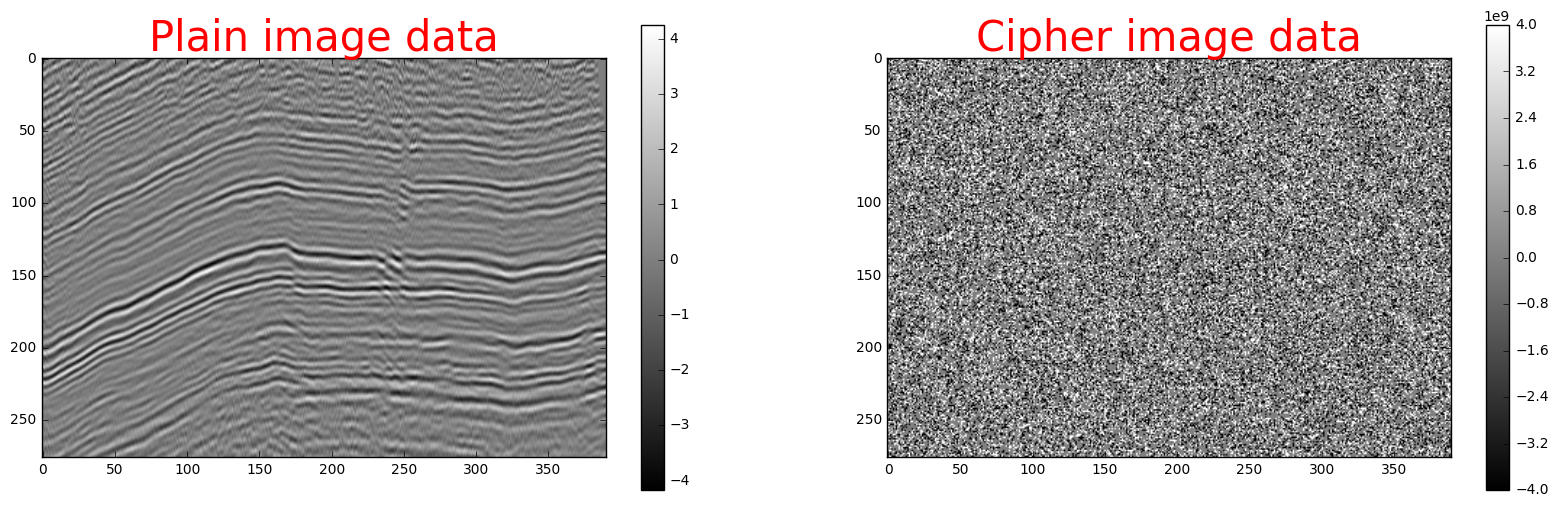

In [17]:
fig = plt.figure()

plt.rcParams['figure.figsize'] = (20, 6)

a=fig.add_subplot(1,2,1)
imgplot = plt.imshow(plain, cmap='gray')
a.set_title('Plain image data', fontsize=30, color='red')
plt.colorbar( orientation ='vertical')

a=fig.add_subplot(1,2,2)
imgplot = plt.imshow(cipher, cmap='gray')
imgplot.set_clim(-4e9,4e9)
a.set_title('Cipher image data', fontsize=30, color='red')
plt.colorbar(orientation='vertical')

That's pretty jumbled. Our encryption algorithm made quick work of that data. The basic tenets of encryption workflows are confusion and diffusion (as per [Shannon, 1949](http://netlab.cs.ucla.edu/wiki/files/shannon1949.pdf)):

1. *Confusion* - *cipherimage* doesn't depend on the key in a simple way. Many bits of the key should be used to encrypt each bit in the cipherimage.


2. *Diffusion* - changing a single bit in the *plainimage* results in a coresponding change in many bits of the *cipherimage*, such that much of the cipherimage is needed to derive information statistically about the plainimage.

---

### Exercises for the reader:

* [HARD] In our TEA algorithm, above, I've used 32 encryption "cycles." Using your new knowledge of encryption algorithms, calculate the confusion and diffusion dependence on number of TEA cycles. For example: coresponding to a single change in the input image, how many bits/bytes/words in the cipherimage will change when we encrypt with one cycle? With 32 cycles?


* [HARDER] Build a TEA decryption algorithm. See if you can recover the original seismic image. Hint: remember to strip off each of the key bits in an order exactly reverse of the encryption sequence.

---

## Encrypt seismic data using a strong algorithm

Let's now use a free tool called [AEScrypt](https://www.aescrypt.com/) to encrypt the above seismic section. Below the -p flag specifies the password, where we've used the string from above. The -e flag specifies "encrypt" (instead of -d: "decrypt").

In [10]:
!aescrypt -p is_52_ytpeienncr_iTghsn_kye._oru_hTsi -e data/seis.bin

Now we'll load the enciphered data into an array for manipulation.

In [11]:
cipher = np.zeros((ns, ntr))

with open('data/seis.bin.aes', 'rb') as f:
    for i in range(ntr):
        for j in range(ns):
            cipher[j,i] = struct.unpack('f', f.read(4))[0]

Let's now view the plainimage data and the cipherimage data side-by-side. 

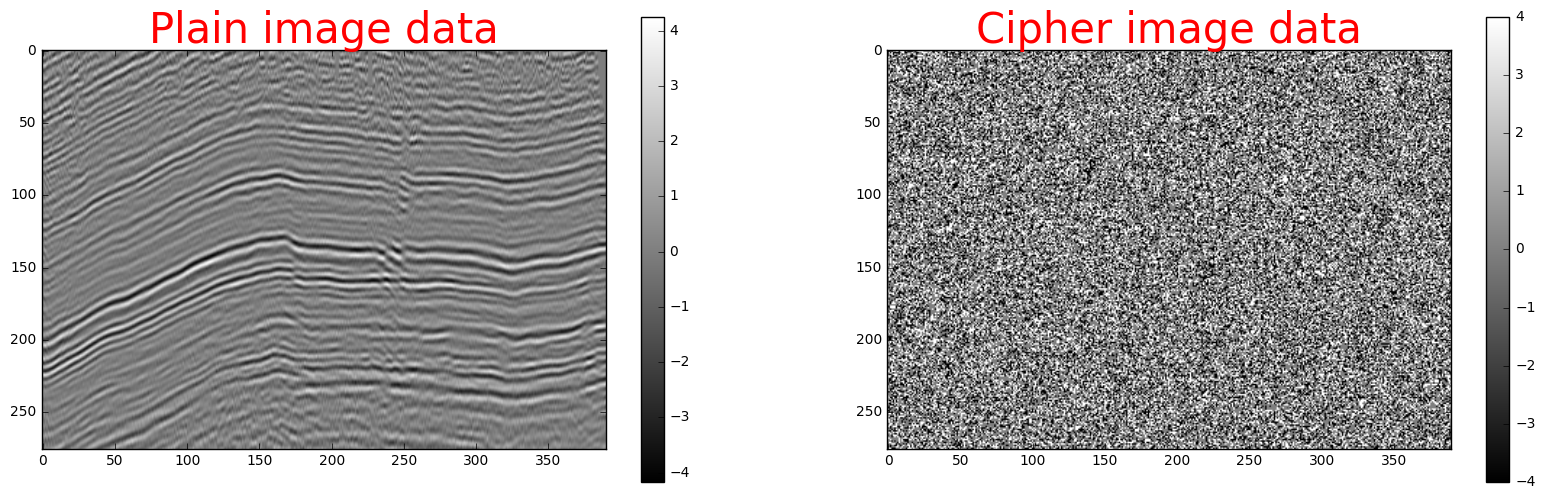

In [15]:
fig = plt.figure()

plt.rcParams['figure.figsize'] = (20, 6)

a=fig.add_subplot(1,2,1)
imgplot = plt.imshow(plain, cmap='gray')
a.set_title('Plain image data', fontsize=30, color='red')
plt.colorbar( orientation ='vertical')

a=fig.add_subplot(1,2,2)
imgplot = plt.imshow(cipher, cmap='gray')
imgplot.set_clim(-4,4)
a.set_title('Cipher image data', fontsize=30, color='red')
plt.colorbar(ticks=range(-4, 5), orientation='vertical')

Obviously, you'd much rather an attacker have access to the cipherimage, not the plainimage.

The discerning reader will notice the grid in the cipher image. This is due to the blockwise operation of the AES algorithm. AES utilizes constant size blocks (128 bits), whereas other substitution-permutation cryptography algorithms can use blocks of varying size.